In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

In [47]:
x_train = pd.read_csv('X_train_merged.csv')
y_train = pd.read_csv('y_train.csv')
y_train = y_train['Genre']
x_train.drop(columns = ['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1', 'track_id', 'Tag1'], inplace=True)
x_test = pd.read_csv('X_test_merged.csv')
y_test = pd.read_csv('y_test.csv')
y_test = y_test['Genre']
x_test.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1','track_id', 'Tag1'], inplace=True)

In [44]:
y_train.value_counts()

Rock          6614
Pop           1204
Metal         1048
Country        852
Rap            779
RnB            646
Electronic     487
Punk           385
Reggae         312
Folk           291
Jazz           269
Latin          202
Blues          195
Name: Genre, dtype: int64

## Ensemble Boosting

As boosting ran well for both the text and audio analysis separately. It was chosen as one of the performers to look at the ensemble data. To limit the time intensity of cross-validation for this method. The test values for parameters were kept within the range of values previously found to be useful

In [49]:
gb = GradientBoostingClassifier(n_estimators=30, max_features=20, random_state = 0)
params = {'learning_rate':[0.025, 0.05, 0.1], 'max_depth':[2, 3, 4, 5]}
gsgb = GridSearchCV(estimator=gb,
                  param_grid=params,
                  n_jobs=1,
                  cv=5,
                  verbose=1)
gsgb.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.025, 0.05, 0.1], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [50]:
dir(gsgb)
print(gsgb.best_score_)
gsgb.best_estimator_

0.49789220114423366


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='deviance', max_depth=2,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [77]:
gb = GradientBoostingClassifier(n_estimators=500, max_features=20, random_state = 0, learning_rate = 0.025, max_depth = 2)
gb.fit(x_train, y_train)
predictions = gb.predict(x_test)

In [78]:
z = (y_test == predictions).sum()
z/len(y_test)

0.4851709304958116

In [79]:
feature_list = list(x_train.columns)
importances = list(gb.feature_importances_)

#List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

#Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Most important features
important = list(filter(lambda x: x[1] >= 0.001, feature_importances))

In [85]:
important[0:11]

[('timbre_6', 0.01),
 ('hand', 0.005),
 ('pass', 0.005),
 ('send', 0.005),
 ('timbre_8', 0.005),
 ('timbre_11', 0.005),
 ('age', 0.004),
 ('devil', 0.004),
 ('hour', 0.004),
 ('see', 0.004),
 ('tell', 0.004)]

Comparing the distributions of the actual and predicted values

In [81]:
y_test.value_counts()

Rock          2148
Pop            411
Metal          345
Country        273
Rap            251
RnB            218
Electronic     180
Folk           120
Punk           119
Reggae         100
Latin           97
Jazz            87
Blues           68
Name: Genre, dtype: int64

In [82]:
pd.Series(predictions).value_counts()

Rock          4399
Punk             4
Jazz             3
Electronic       2
Blues            2
Metal            2
Rap              2
Latin            1
RnB              1
Reggae           1
dtype: int64

Looking at the confusion matrix

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
d = list(set(y_test.values))
conf = confusion_matrix(y_test, predictions, labels = d)
normed_matrix = normalize(conf, axis=1, norm='l1')

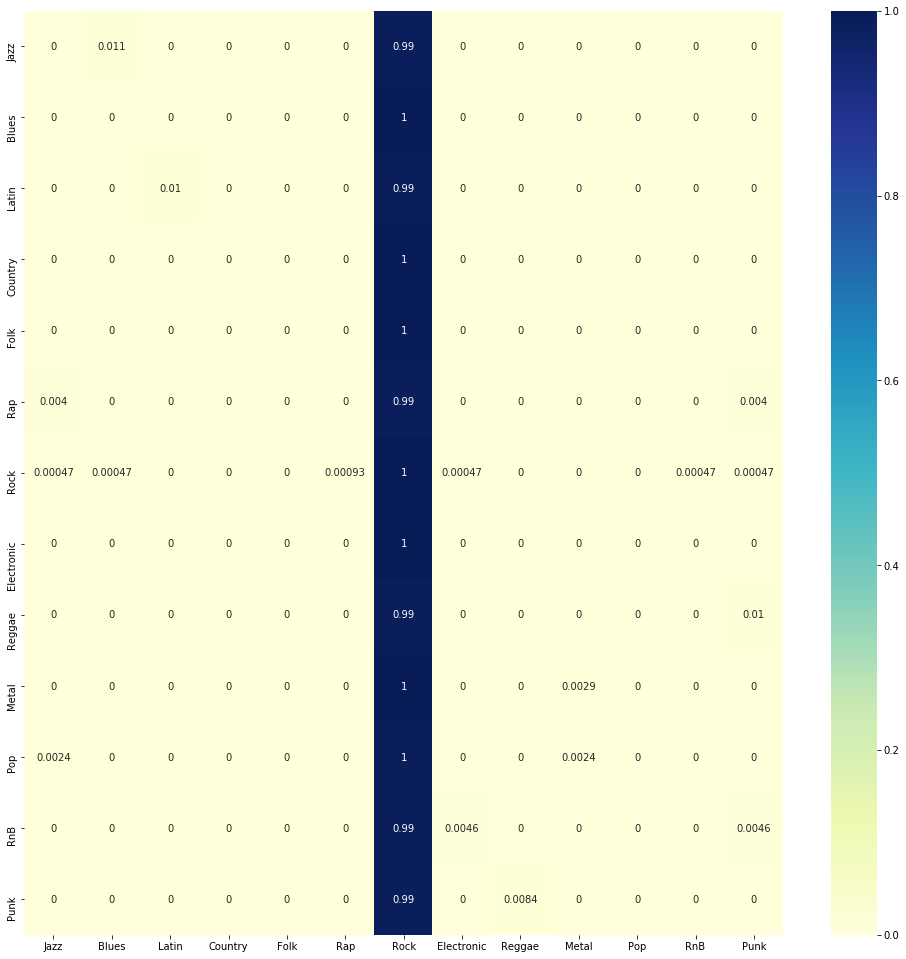

In [84]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)